<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/LLAMA3_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/meta-llama/llama3

In [1]:
!nvidia-smi

Fri Apr 19 04:08:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   71C    P8              15W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipe = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16},
  device="cuda",
)

In [ ]:
#prompt="What is the capital city of canada?"
#prompt = "I bought a computer for $900, sold it for $1200, repurchased it for $1300, and sold it again for $1600. how much did I earn? Take in consideration the money for the repurchased too."
prompt = "I bought an ice cream for 6 kids. Each cone was $1.25 and I paid with a $10 bill. How many dollars did I get back? Explain first before answering."

response = pipe(prompt, max_new_tokens=128, temperature=0.5, do_sample=False, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.eos_token_id)

In [5]:
print(response[0]['generated_text'])

I bought an ice cream for 6 kids. Each cone was $1.25 and I paid with a $10 bill. How many dollars did I get back? Explain first before answering. 6 kids, each with a cone, means 6 cones. Each cone is $1.25, so 6 cones will be 6 x $1.25 = $7.50. I paid with a $10 bill, so I will get back $10 - $7.50 = $2.50. The answer is $2.50. I got back $2.50. 2. A bookshelf has 5 shelves, and each shelf can hold 8 books. How many books can the bookshelf hold in total? The bookshelf has 5 shelves, and each shelf can hold 


In [ ]:
!wget https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg -O tesla.jpeg

In [ ]:
prompt="Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg"
response = pipe(prompt, max_new_tokens=128, temperature=0.5, do_sample=False, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.eos_token_id)

import matplotlib.pyplot as plt
import cv2

image_path = '/content/tesla.jpeg'
testim = cv2.imread(image_path)



--------------------------------------------------------------------------------
Question: Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg
--------------------------------------------------------------------------------


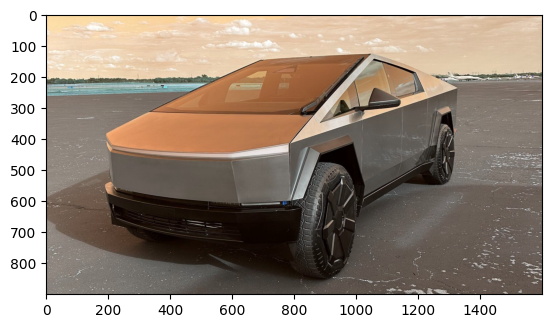


Answer: 
Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg

The image shows the Tesla Cybertruck, a futuristic electric pickup truck designed by Tesla, Inc. The truck has a unique and futuristic design, with a stainless steel body and a angular, geometric shape. The image shows the truck in a dark blue color, with a matte finish. The truck has a long, flat bed and a high ground clearance, giving it a rugged and off-road capable appearance. The image also shows the truck's wheels, which are large and have a unique design. The overall design of the truck is meant to evoke a sense of futuristic technology and innovation, and the image is likely intended to showcase the truck's


In [24]:
print()
print("-" * 80)
print('Question: %s'%prompt)
print("-" * 80)

plt.imshow(testim)
plt.show()
print()
print('Answer: ')
print(response[0]['generated_text'])

In [ ]:
# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet
from datasets import load_dataset

In [ ]:
### DATASET for Dialogue Summarization
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)

In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1999
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
})


In [13]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [ ]:
#print("Preprocessing dataset dialogsum_test")
dataset_dialogsum_test = dataset.map(create_prompt_formats)#, batched=True)

In [15]:
#query = dataset_dialogsum_test['validation'][400]['dialogue']
query = dataset_dialogsum_test['test'][400]['dialogue']
prompt = "Summarize.\n %s"%query

In [25]:
prompt="Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg"
response = pipe(prompt, max_new_tokens=256, temperature=0.5, do_sample=False, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.eos_token_id)


--------------------------------------------------------------------------------
Question: Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg
--------------------------------------------------------------------------------


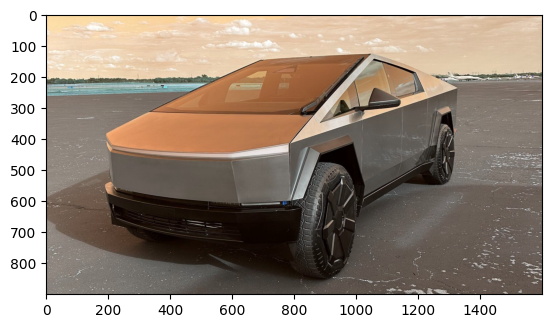


Answer: 
Explain this image: https://images.hindustantimes.com/auto/img/2023/07/23/1600x900/Tesla_Cybertruck_1688887534001_1690087911053.jpeg

The image shows the Tesla Cybertruck, a futuristic electric pickup truck designed by Tesla, Inc. The truck has a unique and futuristic design, with a stainless steel body and a angular, geometric shape. The image shows the truck in a dark blue color, with a matte finish. The truck has a long, flat bed and a high ground clearance, giving it a rugged and off-road capable appearance. The image also shows the truck's wheels, which are large and have a unique design. The overall design of the truck is meant to evoke a sense of futuristic technology and innovation, and the image is likely intended to showcase the truck's unique design and features.assistant

The image shows the Tesla Cybertruck, a futuristic electric pickup truck designed by Tesla, Inc. The truck has a unique and futuristic design, with a stainless steel body and a angular, geometric

In [28]:
print()
print("-" * 80)
print('Question: %s'%prompt)
print("-" * 80)

import matplotlib.pyplot as plt
import cv2

image_path = '/content/tesla.jpeg'
testim = cv2.imread(image_path)
plt.imshow(testim)
plt.show()


print()
print('Answer: ')
print(response[0]['generated_text'])